train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df_sample =  pd.read_csv('test.csv')

In [3]:
column_alias = {
    'PassengerId': 'id', 'HomePlanet': 'home', 'CryoSleep': 'is_cryo', 'Cabin': 'cab', 'Destination': 'dest', 
    'Age': 'age',
    'VIP': 'vip', 'RoomService': 'has_room', 'FoodCourt': 'has_food', 'ShoppingMall':'has_shop',
    'Spa': 'has_spa', 'VRDeck': 'has_vrd',
    'Name': 'name', 'Transported': 'target'
}


def count_relatives(x):
    return df[df['family'] == x].shape[0]

def by_relatives(x, key):
    try:
        res = df[(df['family']==x)&(~pd.isna(df[key]))][key].values[0]
        return res
    except IndexError:
        return np.nan
    
def set_total(row):
    all_nan = True
    
    total = 0
    for key in ['has_room', 'has_food', 'has_shop', 'has_spa', 'has_vrd']:
        if not pd.isna(row[key]):
            total += row[key]
            all_nan = False    
    return total if not all_nan else np.nan 

sides = {'P': 'left', 'S':'right'}

def resolve_cab(row):
    x = row['cab']
    if isinstance(x, str) and x.find('/') != -1 and len(x.split('/')) == 3:
        res = x.split('/')
        deck, num, side = res[0], int(res[1]), sides.get(res[2])
        return  deck, num, side
    else:
        return 'no_deck', None, 'no_side' 

def resolve_name(row):
    x = row['name']
    if isinstance(x, str) and len(x.split(' ')) > 1:
        res = x.split(' ')
        return  res[0], res[1]
    else:
        return None, None


In [4]:
# Переименование столбцов
df = df.rename(columns=column_alias)
df_sample = df_sample.rename(columns=column_alias)
# замена типа
df = df.astype({'target': 'int32','is_cryo': float,  'vip': float })
df_sample = df_sample.astype({'is_cryo': float,  'vip': float })
df.head()

,id,home,is_cryo,cab,dest,age,vip,has_room,has_food,has_shop,has_spa,has_vrd,name,target
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [5]:
# Выделение идентификатора семьи 
df['family'] = df['id'].apply(lambda x: x.split('_')[0])
df_sample['family'] = df_sample['id'].apply(lambda x: x.split('_')[0])

# количество родственников у пассажира 
#(это было надо чтоб посмотреть как семьи с разным количеством членов занимают каюты) 
df['family_size'] = df['family'].apply(lambda x: count_relatives(x))
df_sample['family_size'] = df_sample['family'].apply(lambda x: count_relatives(x))

# Заполнение пропущенных кают на каюты родственников (на номер каюты наплевать, 
# важна сторона а родственники на одной стороне были даже если палубы разные)
df['cab'] = df.loc[:,['cab', 'family']].apply(lambda x: by_relatives(x[1], 'cab') if pd.isna(x[0]) else x[0], axis=1)
df_sample['cab'] = df_sample.loc[:,['cab', 'family']].apply(lambda x: by_relatives(x[1], 'cab') if pd.isna(x[0]) else x[0], axis=1)

# определим номер комнаты, палубу и сторону из номера каюты
df["deck"], df["num"], df['side'] = zip(*df.apply(resolve_cab, axis=1))
df_sample["deck"], df_sample["num"], df_sample['side'] = zip(*df_sample.apply(resolve_cab, axis=1))

# Заполним пропущенные Home и Destination по родственникам
df['home'] = df.loc[:,['home', 'family']].apply(lambda x: by_relatives(x[1], 'home') if pd.isna(x[0]) else x[0], axis=1)
df['dest'] = df.loc[:,['dest', 'family']].apply(lambda x: by_relatives(x[1], 'dest') if pd.isna(x[0]) else x[0], axis=1)

df_sample['home'] = df_sample.loc[:,['home', 'family']].apply(lambda x: by_relatives(x[1], 'home') if pd.isna(x[0]) else x[0], axis=1)
df_sample['dest'] = df_sample.loc[:,['dest', 'family']].apply(lambda x: by_relatives(x[1], 'dest') if pd.isna(x[0]) else x[0], axis=1)
# проставим расходы 0 где is_cryo (если спит значит не тратит, если не тратит  это еще не значит что спит)
# If CryoSleep is True or Age is 12 or less, no money is used
  
for key in ['has_room', 'has_food', 'has_shop', 'has_spa', 'has_vrd']:
    df[key] = df.loc[:, [key, 'is_cryo', 'age']].apply(lambda x: 0.0 if pd.isna(x[0]) and (x[1] == 1.0 or x[2] <=12.0) else x[0], axis=1)
    df_sample[key] = df_sample.loc[:, [key, 'is_cryo', 'age']].apply(lambda x: 0.0 if pd.isna(x[0]) and (x[1] == 1.0 or x[2] <=12.0) else x[0], axis=1)
    
# Вычислим суммарный расход средств на увеселения и роскошества
df['no_expenses'] = np.nan
df['no_expenses'] = df.apply(lambda x: int(set_total(x) == 0.), axis=1)

df_sample['no_expenses'] = np.nan
df_sample['no_expenses'] = df_sample.apply(lambda x: int(set_total(x) == 0.), axis=1)
# посмотрим что вышло

In [75]:
# decks = {'A': 1, 'B': 2, 'C':3, 'D':4,'E':5, 'F':6, 'G':7, 'T':8}
# If the Cabin is A, B, C, or T, it is Europa, and if the Cabin is G, it is Earth.
# по сопоставлению порта отплытия и занимаемых палуб. Табличка в экселе записана 
df['home'] = df.loc[:, ['home', 'deck']].apply(lambda x: 'Earth' if x[1] == 'G' else x[0], axis=1)
df['home'] = df.loc[:, ['home', 'deck']].apply(lambda x: 'Europa' if x[1] in ('A', 'B', 'C', 'T') else x[0], axis=1)

df_sample['home'] = df_sample.loc[:, ['home', 'deck']].apply(lambda x: 'Earth' if x[1] == 'G' else x[0], axis=1)
df_sample['home'] = df_sample.loc[:, ['home', 'deck']].apply(lambda x: 'Europa' if x[1] in ('A', 'B', 'C', 'T') else x[0], axis=1)

In [7]:
df['first_name'], df["last_name"] = zip(*df.apply(resolve_name, axis=1))
df_sample['first_name'], df_sample["last_name"] = zip(*df_sample.apply(resolve_name, axis=1))



planets = ('Earth', 'Mars', 'Europa')

def home_by_name(home, name):
    if home:
        return home
    elif name:
        for p in planets:
            if name in df[df['home'] == p]['last_name'].unique():
                return p
    return None    

df['home'] = df.loc[:, ['home', 'last_name']].apply(lambda x: home_by_name(x[0], x[1]), axis=1)
df_sample['home'] = df_sample.loc[:, ['home', 'last_name']].apply(lambda x: home_by_name(x[0], x[1]), axis=1)

In [8]:
df['dest'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [9]:
# как заполнить вип. 
# In the case of Earth, VIP is filled with False because VIP is only from Europa or Mars.
# If CabinDeck is T, VIP is filled with False.
# If Age is less than 25 years old in Europa, fill VIP with False.
# If you are over 18 years old in Mars and cryoSleep is False and destination is not 55 Cancrie, complete VIP to False.
def set_vip(row):
    if row.get('vip') in (0.0, 1.0):
        return row.get('vip')
    if row.get('home') == 'Earth' or row.get('deck') == 'T':
        return 0.0
    if row.get('age') < 25 and row.get('home') == 'Europa':
        return 0.0
    if row.get('age') > 18 and row.get('home') == 'Mars' and row.get('dest') != '55 Cancri e' and row.get('is_cryo') == 0.0:
        return 0.0
    
    return row.get('vip')
df['vip'] = df.apply(lambda x: set_vip(x), axis=1)
df_sample['vip'] = df_sample.apply(lambda x: set_vip(x), axis=1)

In [10]:
# If the passenger is over 18 years old and has no invoice and cryoSleep is False, 
# the destination is complemented to TRAPPIST-1e.

df['dest'] = df.loc[:, ['dest', 'age', 'no_expenses', 'is_cryo']].apply(lambda x: 'TRAPPIST-1e' if pd.isna(x[0]) and x[1] > 18.0 and x[2] == 1 and x[3] == 0.0 else x[0], axis=1)
df_sample['dest'] = df_sample.loc[:, ['dest', 'age', 'no_expenses', 'is_cryo']].apply(lambda x: 'TRAPPIST-1e' if pd.isna(x[0]) and x[1] > 18.0 and x[2] == 1 and x[3] == 0.0 else x[0], axis=1)


In [11]:
df.loc[:, ['age', 'has_room', 'has_food', 'has_shop', 'has_spa', 'has_vrd', 'is_cryo']].describe()

,age,has_room,has_food,has_shop,has_spa,has_vrd,is_cryo
count,8514.000000,8586.000000,8587.000000,8590.000000,8579.000000,8586.000000,8476.000000
mean,28.827930,222.751106,453.969605,171.605588,308.636321,301.978803,0.358306
std,14.489021,664.162853,1604.828124,601.292045,1132.465664,1140.680220,0.479531
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,44.000000,69.500000,24.000000,58.000000,43.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [14]:
fill_values = {'has_room': 0.0, 'has_food': 0.0, 'has_shop': 0.0, 'has_spa': 0.0, 'has_vrd': 0.0, 'age': 27.0,
              'dest': 'no_dest', 'home': 'no_home', 'is_cryo': 0.0, 'vip': 0.0} 
df = df.fillna(value=fill_values)
df_sample = df_sample.fillna(value=fill_values)


In [15]:
df_sample.isnull().sum()

id               0
home             0
is_cryo          0
cab            100
dest             0
age              0
vip              0
has_room         0
has_food         0
has_shop         0
has_spa          0
has_vrd          0
name            94
family           0
family_size      0
deck             0
num            100
side             0
no_expenses      0
first_name      94
last_name       94
dtype: int64

In [16]:
def create_home_dest_features(data):
    
    df_home = pd.get_dummies(data['home'])
    data = pd.merge(data, df_home, left_index=True, right_index=True)
    df_dest = pd.get_dummies(data['dest'])
    data = pd.merge(data, df_dest, left_index=True, right_index=True)

    home_dest_cols = {'Earth': 'from_ea', 'Europa':'from_eu', 'Mars':'from_ma', '55 Cancri e': 'to_can',
       'PSO J318.5-22': 'to_pso', 'TRAPPIST-1e': 'to_trap'}
    data = data.rename(columns=home_dest_cols)
    return data

In [17]:
df = create_home_dest_features(df)
df_sample = create_home_dest_features(df_sample)
df.columns

Index(['id', 'home', 'is_cryo', 'cab', 'dest', 'age', 'vip', 'has_room',
       'has_food', 'has_shop', 'has_spa', 'has_vrd', 'name', 'target',
       'family', 'family_size', 'deck', 'num', 'side', 'no_expenses',
       'first_name', 'last_name', 'from_ea', 'from_eu', 'from_ma', 'no_home',
       'to_can', 'to_pso', 'to_trap', 'no_dest'],
      dtype='object')

In [18]:
def create_deck_side_features(data):
    
    df_deck = pd.get_dummies(data['deck'])
    data = pd.merge(data, df_deck, left_index=True, right_index=True)
    df_side = pd.get_dummies(data['side'])
    data = pd.merge(data, df_side, left_index=True, right_index=True)
    return data

In [19]:
df = create_deck_side_features(df)
df_sample = create_deck_side_features(df_sample)
df.columns

Index(['id', 'home', 'is_cryo', 'cab', 'dest', 'age', 'vip', 'has_room',
       'has_food', 'has_shop', 'has_spa', 'has_vrd', 'name', 'target',
       'family', 'family_size', 'deck', 'num', 'side', 'no_expenses',
       'first_name', 'last_name', 'from_ea', 'from_eu', 'from_ma', 'no_home',
       'to_can', 'to_pso', 'to_trap', 'no_dest', 'A', 'B', 'C', 'D', 'E', 'F',
       'G', 'T', 'no_deck', 'left', 'no_side', 'right'],
      dtype='object')

<AxesSubplot:>

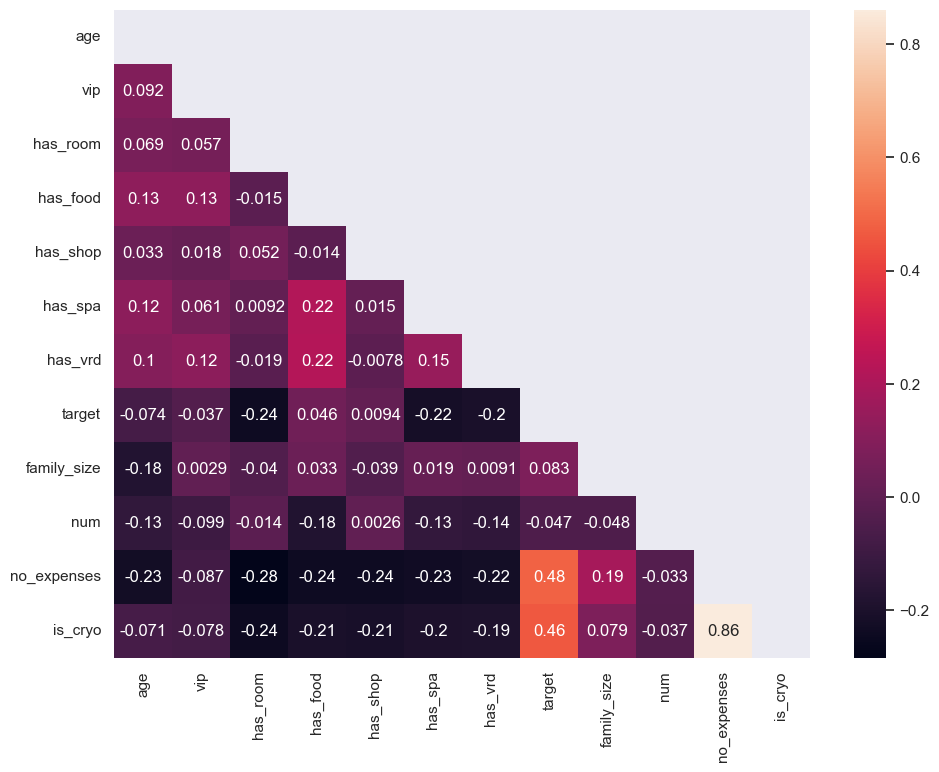

In [23]:
correlation_matrix = df.loc[:, ['age', 'vip', 'has_room',
       'has_food', 'has_shop', 'has_spa', 'has_vrd', 'name', 'target',
       'family', 'family_size', 'deck', 'num', 'side', 'no_expenses', 'is_cryo']].corr()
sns.set(rc = {'figure.figsize':(10,8)})
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, fmt='.2g', annot=True)



In [24]:
work_features = ['age', 'vip', 'has_room',
       'has_food', 'has_shop', 'has_spa', 'has_vrd',
       'family_size', 'no_expenses',
       'from_ea', 'from_eu', 'from_ma', 'no_home',
       'to_can', 'to_pso', 'to_trap', 'no_dest', 'A', 'B', 'C', 'D', 'E', 'F',
       'G', 'T', 'no_deck', 'left', 'no_side', 'right']
df_work = df.loc[:, work_features].copy(deep=True)
df_work= df_work.astype(np.int32)
df_work.dtypes

age            int32
vip            int32
has_room       int32
has_food       int32
has_shop       int32
has_spa        int32
has_vrd        int32
family_size    int32
no_expenses    int32
from_ea        int32
from_eu        int32
from_ma        int32
no_home        int32
to_can         int32
to_pso         int32
to_trap        int32
no_dest        int32
A              int32
B              int32
C              int32
D              int32
E              int32
F              int32
G              int32
T              int32
no_deck        int32
left           int32
no_side        int32
right          int32
dtype: object

In [25]:
from sklearn.model_selection import train_test_split
X = df_work
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X.columns

Index(['age', 'vip', 'has_room', 'has_food', 'has_shop', 'has_spa', 'has_vrd',
       'family_size', 'no_expenses', 'from_ea', 'from_eu', 'from_ma',
       'no_home', 'to_can', 'to_pso', 'to_trap', 'no_dest', 'A', 'B', 'C', 'D',
       'E', 'F', 'G', 'T', 'no_deck', 'left', 'no_side', 'right'],
      dtype='object')

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
from sklearn.metrics import classification_report

In [171]:
from sklearn.tree import DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=0)


# fit the model
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

In [172]:
y_pred_gini = clf_gini.predict(X_train)

In [173]:

print(classification_report(y_train, y_pred_gini))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      3452
           1       0.78      0.80      0.79      3502

    accuracy                           0.79      6954
   macro avg       0.79      0.78      0.78      6954
weighted avg       0.79      0.79      0.78      6954



In [174]:
y_pred_gini_test = clf_gini.predict(X_test)

In [175]:
print(classification_report(y_test, y_pred_gini_test))

              precision    recall  f1-score   support

           0       0.78      0.75      0.77       863
           1       0.76      0.79      0.78       876

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



In [204]:
clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)


# fit the model
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)

In [205]:
y_pred_entr = clf_entropy.predict(X_train)

In [206]:
print(classification_report(y_train, y_pred_entr))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      3452
           1       0.78      0.86      0.82      3502

    accuracy                           0.81      6954
   macro avg       0.81      0.81      0.80      6954
weighted avg       0.81      0.81      0.80      6954



In [207]:
y_pred_entr_test = clf_entropy.predict(X_test)

In [208]:
print(classification_report(y_test, y_pred_entr_test))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76       863
           1       0.75      0.83      0.79       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [219]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [220]:
y_pred_knn_test = knn.predict(X_test)
y_pred_knn_train = knn.predict(X_train)

In [221]:
print(classification_report(y_train, y_pred_knn_train ))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      3452
           1       0.84      0.83      0.83      3502

    accuracy                           0.83      6954
   macro avg       0.83      0.83      0.83      6954
weighted avg       0.83      0.83      0.83      6954



In [222]:
print(classification_report(y_test, y_pred_knn_test))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       863
           1       0.77      0.76      0.77       876

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
#'linear', 'poly', 'rbf 'C': [0.1, 1, 10], 'gamma': [0.00001, 0.0001, 0.001, 0.01, 1]}
model = SVC()
param_grid = {'kernel': ['poly'], 
              'C': [0.1, 1, 10],
              'gamma': [0.00001, 0.001, 1]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

In [ ]:
model = grid.best_estimator_
y_pred_svm_train = model.predict(X_train)
y_pred_svm_test = model.predict(X_test)

In [ ]:
print(classification_report(y_train, y_pred_svm_train))